# Step 4. 연봉 그룹화

- 분류 모델을 통한 예측을 하기 위해 연봉 데이터를 연속형에서 범주형으로 변경하는 작업
- 포지션별 연봉(그룹) 변수와의 스피어만 상관계수를 활용하여 상관 분석을 진행

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 그래프 한글화

In [2]:
# 실행 후 런타임 재시작 필요
!apt install fonts-nanum-coding
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
The following NEW packages will be installed:
  fonts-nanum-coding
0 upgraded, 1 newly installed, 0 to remove and 7 not upgraded.
Need to get 1,083 kB of archives.
After this operation, 4,610 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 fonts-nanum-coding all 2.5-1 [1,083 kB]
Fetched 1,083 kB in 0s (8,409 kB/s)
Selecting previously unselected package fonts-nanum-coding.
(Reading database ... 124015 files and directories currently installed.)
Preparing to unpack .../fonts-nanum-coding_2.5-1_all.deb ...
Unpacking fonts-nanum-coding (2.5-1) ...
Setting up fonts-nanum-coding (2.5-1) ...
Processing triggers for fontconfig (2.12.6-0ubuntu2) ...
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/

In [3]:
# 설치된 폰트 확인
for f in fm.get_fontconfig_fonts():
    if 'Nanum' in f:
        print(f)

/usr/share/fonts/truetype/nanum/NanumGothicCoding-Bold.ttf
/usr/share/fonts/truetype/nanum/NanumGothicCoding.ttf


In [4]:
# matplotlib 설정
plt.rcParams['figure.figsize'] = (14, 4)
plt.rcParams['font.size'] = 13
font_location = '/usr/share/fonts/truetype/nanum/NanumGothicCoding.ttf'
font_name = fm.FontProperties(fname=font_location).get_name()
plt.rc('font', family=font_name)

# 데이터 & 라이브러리 불러오기

In [18]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

from scipy import stats

In [19]:
data_path = '/content/drive/MyDrive/Colab Notebooks/캡스톤_4조/dataset/'
data = pd.read_csv(data_path + 'epl_data.csv')

del data['Unnamed: 0']
del data['이름'], data['클럽팀']
data = data[data['연봉(€)']!=0]

# 결측치 확인 및 대체
data[data['시장가치'].isnull()]
data = data.fillna(2)

def change(x):
    cat = ''
    if x == 'Goalkeeper': cat = 0
    elif x == 'Defender': cat = 1
    elif x == 'Midfielder': cat = 2
    elif x == 'Forward': cat = 3
    return cat

data['포지션'] = data.포지션.apply(lambda x: change(x))
data

,연봉(€),시즌,포지션,전체 출장 시간,전체 골,전체 어시스트,클린시트,실점,경고,퇴장,...,90분당 골,90분당 실점,카드/90분,공격수 순위,미드필더 순위,수비수 순위,득점 순위,나이,시장가치,승점
0,5992270.0,2022,2,508.0,0.0,0.0,2.0,5.0,2.0,0.0,...,0.00,0.89,0.35,108.0,121.0,-1.0,9.0,36,2.0,27
1,5093430.0,2022,2,507.0,0.0,1.0,2.0,6.0,1.0,0.0,...,0.00,1.07,0.18,101.0,49.0,-1.0,8.0,24,45.0,27
2,4609439.0,2022,1,263.0,0.0,0.0,2.0,2.0,1.0,0.0,...,0.00,0.68,0.34,-1.0,-1.0,-1.0,4.0,29,18.0,27
3,3595362.0,2022,3,503.0,2.0,0.0,3.0,7.0,1.0,0.0,...,0.36,1.25,0.18,26.0,226.0,-1.0,1.0,27,20.0,27
4,2996135.0,2022,2,720.0,1.0,0.0,3.0,8.0,5.0,0.0,...,0.13,1.00,0.63,89.0,225.0,-1.0,2.0,25,40.0,27
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3193,2996135.0,2014,1,349.0,0.0,1.0,1.0,3.0,0.0,0.0,...,0.00,0.77,0.00,284.0,29.0,14.0,27.0,24,12.0,75
3194,2756444.0,2014,1,1658.0,0.0,3.0,7.0,20.0,3.0,0.0,...,0.00,1.09,0.16,336.0,73.0,56.0,26.0,25,13.0,75
3195,2696522.0,2014,1,1569.0,1.0,1.0,8.0,18.0,9.0,1.0,...,0.06,1.03,0.52,199.0,190.0,44.0,14.0,19,12.0,75
3196,1797681.0,2014,2,1663.0,0.0,0.0,7.0,12.0,5.0,0.0,...,0.00,0.65,0.27,343.0,371.0,-1.0,21.0,23,3.0,75


# 시장 가치에 따라 등급화

In [20]:
data['가치 등급'] = pd.qcut(data['시장가치'], 5, labels=[5, 4, 3, 2, 1])

print('1등급: {}m € 이상'.format(round(np.quantile(data['시장가치'], .8))))
print('2등급: {}m € 미만'.format(round(np.quantile(data['시장가치'], .8))))
print('3등급: {}m € 미만'.format(round(np.quantile(data['시장가치'], .6))))
print('4등급: {}m € 미만'.format(round(np.quantile(data['시장가치'], .4))))
print('5등급: {}m € 미만'.format(round(np.quantile(data['시장가치'], .2))))

1등급: 25m € 이상
2등급: 25m € 미만
3등급: 13m € 미만
4등급: 7m € 미만
5등급: 4m € 미만


Text(0.5, 1.0, '시장가치에 따라 그룹화')

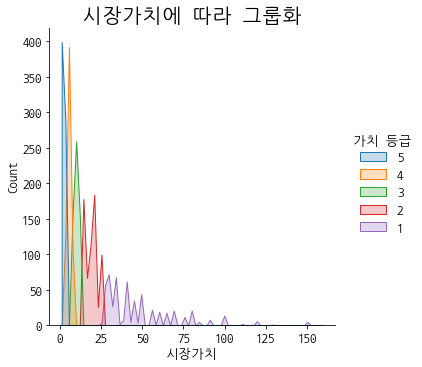

In [21]:
# 시장가치 등급 시각화
sns.displot(data, x='시장가치', hue='가치 등급', element='poly')
plt.title('시장가치에 따라 그룹화', size=20)

In [22]:
data = data.astype({'가치 등급':'int'})
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3095 entries, 0 to 3197
Data columns (total 23 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   연봉(€)      3095 non-null   float64
 1   시즌         3095 non-null   int64  
 2   포지션        3095 non-null   int64  
 3   전체 출장 시간   3095 non-null   float64
 4   전체 골       3095 non-null   float64
 5   전체 어시스트    3095 non-null   float64
 6   클린시트       3095 non-null   float64
 7   실점         3095 non-null   float64
 8   경고         3095 non-null   float64
 9   퇴장         3095 non-null   float64
 10  90분당 골 관여  3095 non-null   float64
 11  90분당 어시스트  3095 non-null   float64
 12  90분당 골     3095 non-null   float64
 13  90분당 실점    3095 non-null   float64
 14  카드/90분     3095 non-null   float64
 15  공격수 순위     3095 non-null   float64
 16  미드필더 순위    3095 non-null   float64
 17  수비수 순위     3095 non-null   float64
 18  득점 순위      3095 non-null   float64
 19  나이         3095 non-null   int64  
 20  시장가치    

In [23]:
del data['시장가치']

# 스피어만 상관계수

In [24]:
data_spearman = data.corr(method='spearman')
data_spearman

,연봉(€),시즌,포지션,전체 출장 시간,전체 골,전체 어시스트,클린시트,실점,경고,퇴장,...,90분당 골,90분당 실점,카드/90분,공격수 순위,미드필더 순위,수비수 순위,득점 순위,나이,승점,가치 등급
연봉(€),1.000000,0.182148,0.113906,0.151131,0.271486,0.233542,0.305159,-0.013866,0.038657,-0.020424,...,0.259435,-0.321759,-0.035945,-0.211668,-0.188082,-0.132532,-0.209081,0.202964,0.497032,-0.678874
시즌,0.182148,1.000000,0.035608,-0.141139,-0.030738,-0.034113,-0.174923,-0.113806,-0.135421,-0.081000,...,0.008914,0.050009,-0.056755,-0.096944,-0.093208,-0.057106,-0.037991,0.007905,0.008393,-0.332901
포지션,0.113906,0.035608,1.000000,-0.098633,0.509814,0.362985,0.089860,-0.099925,0.022598,-0.016346,...,0.566111,-0.046057,0.070962,-0.485489,-0.330782,-0.816756,-0.486902,-0.161222,-0.006357,-0.185093
전체 출장 시간,0.151131,-0.141139,-0.098633,1.000000,0.360542,0.395268,0.757147,0.891053,0.566558,0.142516,...,0.151011,-0.133138,0.037458,0.161163,0.134116,0.143849,-0.270782,0.075857,0.048673,-0.199819
전체 골,0.271486,-0.030738,0.509814,0.360542,1.000000,0.516633,0.425085,0.270981,0.235730,0.062013,...,0.945173,-0.173127,0.023747,-0.710756,-0.271533,-0.370657,-0.903757,-0.073473,0.183631,-0.341430
전체 어시스트,0.233542,-0.034113,0.362985,0.395268,0.516633,1.000000,0.439381,0.295796,0.254047,0.052823,...,0.424199,-0.177796,0.020774,-0.262052,-0.702468,-0.301984,-0.425708,-0.085209,0.199700,-0.294134
클린시트,0.305159,-0.174923,0.089860,0.757147,0.425085,0.439381,1.000000,0.482725,0.399091,0.087793,...,0.278064,-0.507514,-0.009510,-0.004619,-0.019254,-0.097040,-0.303685,-0.004925,0.407876,-0.328895
실점,-0.013866,-0.113806,-0.099925,0.891053,0.270981,0.295796,0.482725,1.000000,0.549837,0.145758,...,0.078777,0.281486,0.081862,0.206005,0.192242,0.212594,-0.212362,0.093220,-0.254159,-0.031201
경고,0.038657,-0.135421,0.022598,0.566558,0.235730,0.254047,0.399091,0.549837,1.000000,0.304711,...,0.097269,-0.012575,0.767434,0.119588,0.102943,0.031316,-0.165219,0.045827,-0.034218,-0.055237
퇴장,-0.020424,-0.081000,-0.016346,0.142516,0.062013,0.052823,0.087793,0.145758,0.304711,1.000000,...,0.028999,0.004320,0.293061,0.036402,0.039658,0.040495,-0.039682,0.032769,-0.035562,0.019941


In [25]:
data_spearman['가치 등급'].sort_values()

연봉(€)       -0.678874
승점          -0.488745
전체 골        -0.341430
90분당 골 관여   -0.337549
시즌          -0.332901
클린시트        -0.328895
90분당 골      -0.323912
전체 어시스트     -0.294134
90분당 어시스트   -0.269126
전체 출장 시간    -0.199819
포지션         -0.185093
경고          -0.055237
실점          -0.031201
퇴장           0.019941
카드/90분       0.056641
수비수 순위       0.207830
미드필더 순위      0.220426
나이           0.227244
공격수 순위       0.248949
득점 순위        0.299586
90분당 실점      0.319433
가치 등급        1.000000
Name: 가치 등급, dtype: float64

# 포지션별 상관 분석

In [47]:
# 포지션에 맞는 데이터 불러오는 함수
def load_data(position):
  data = pd.read_csv(data_path + 'epl_{}_data.csv'.format(position))
  data = data.fillna(2)
  data['가치 등급'] = pd.qcut(data['시장가치'], 5, labels=[5, 4, 3, 2, 1])
  data = data.astype({'가치 등급':'int'})
  del data['Unnamed: 0'], data['이름'], data['포지션'], data['클럽팀'], data['시장가치']
  return data

# 연봉과의 상관계수를 반환하는 함수
def corr(data, method):
  data_pearson = data.corr(method=method)
  result = data_pearson['가치 등급'].sort_values()
  return result

## GK

In [44]:
GK = load_data('GK')
corr(GK, 'spearman')

연봉(€)       -0.729153
클린시트        -0.543866
전체 출장 시간    -0.499469
승점          -0.399601
시즌          -0.340249
실점          -0.335728
공격수 순위      -0.269035
경고          -0.230459
미드필더 순위     -0.200824
퇴장          -0.156374
카드/90분      -0.141949
전체 어시스트     -0.104847
90분당 어시스트   -0.104642
90분당 골 관여   -0.104642
득점 순위       -0.007304
수비수 순위       0.087861
나이           0.376807
90분당 실점      0.385804
가치 등급        1.000000
전체 골              NaN
90분당 골            NaN
Name: 가치 등급, dtype: float64

## DF

In [45]:
DF = load_data('DF')
corr(DF, 'spearman')

연봉(€)       -0.658902
승점          -0.505094
시즌          -0.341918
클린시트        -0.294287
전체 골        -0.228124
90분당 골 관여   -0.221886
90분당 골      -0.210492
전체 출장 시간    -0.161574
전체 어시스트     -0.149822
90분당 어시스트   -0.138260
경고          -0.032302
퇴장           0.013330
실점           0.023356
카드/90분       0.083791
미드필더 순위      0.126029
득점 순위        0.173582
공격수 순위       0.177054
나이           0.209634
수비수 순위       0.354532
90분당 실점      0.371171
가치 등급        1.000000
Name: 가치 등급, dtype: float64

## MF

In [49]:
MF = load_data('MF')
corr(MF, 'spearman')

연봉(€)       -0.626963
승점          -0.480818
전체 골        -0.357515
90분당 골 관여   -0.355311
시즌          -0.351144
90분당 골      -0.347228
전체 어시스트     -0.307754
클린시트        -0.275788
90분당 어시스트   -0.265310
전체 출장 시간    -0.178645
경고          -0.022090
실점          -0.015160
퇴장           0.048623
카드/90분       0.095044
나이           0.204961
미드필더 순위      0.250166
90분당 실점      0.280281
득점 순위        0.314505
공격수 순위       0.316920
가치 등급        1.000000
수비수 순위            NaN
Name: 가치 등급, dtype: float64

## FW

In [50]:
FW = load_data('FW')
corr(FW, 'spearman')

연봉(€)       -0.682907
승점          -0.521761
90분당 골 관여   -0.469585
전체 골        -0.432020
90분당 골      -0.417493
전체 어시스트     -0.395983
클린시트        -0.372871
전체 출장 시간    -0.323013
90분당 어시스트   -0.293498
시즌          -0.291869
실점          -0.180308
경고          -0.072990
퇴장          -0.032040
나이           0.106502
카드/90분       0.109452
90분당 실점      0.284181
미드필더 순위      0.305222
득점 순위        0.347057
공격수 순위       0.358189
가치 등급        1.000000
수비수 순위            NaN
Name: 가치 등급, dtype: float64

# 데이터 새로 저장

In [51]:
# 포지션별 데이터 저장
GK.to_csv('/content/drive/MyDrive/Colab Notebooks/캡스톤_4조/dataset/epl_GK_grade_data.csv')
DF.to_csv('/content/drive/MyDrive/Colab Notebooks/캡스톤_4조/dataset/epl_DF_grade_data.csv')
MF.to_csv('/content/drive/MyDrive/Colab Notebooks/캡스톤_4조/dataset/epl_MF_grade_data.csv')
FW.to_csv('/content/drive/MyDrive/Colab Notebooks/캡스톤_4조/dataset/epl_FW_grade_data.csv')

In [52]:
# 데이터프레임을 csv로 저장
data.to_csv('/content/drive/MyDrive/Colab Notebooks/캡스톤_4조/dataset/epl_grade_data.csv')